In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import slic, felzenszwalb
from skimage.measure import label, regionprops
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects

In [3]:
# Paths
data_path = "./images"
ground_path = "./ground"

In [4]:
def load_images():
    images = {}
    masks = {}
    for file in os.listdir(data_path):
        if file.endswith(".jpg"):
            img_id = file.split(".")[0]
            mask_file = f"{img_id}_segmentation.png"
            
            img_path = os.path.join(data_path, file)
            mask_path = os.path.join(ground_path, mask_file)
            
            if os.path.exists(mask_path):
                images[img_id] = cv2.imread(img_path)
                masks[img_id] = cv2.imread(mask_path, 0)
    return images, masks

images, masks = load_images()

In [5]:
# Noise Reduction
def apply_filters(image):
    gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 1)
    median_filtered = cv2.medianBlur(image, 5)
    return gaussian_filtered, median_filtered

In [6]:
# K-Means Segmentation
def kmeans_segmentation(image, k=3):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_flat = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(img_flat)
    segmented = labels.reshape(image.shape[:2])
    return segmented

In [7]:
def graph_segmentation(image):
    segments = felzenszwalb(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), scale=100, sigma=0.5, min_size=50)
    return segments

In [12]:
# Region Growing with Boundary Checks
def region_growing(image, seed_point):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray, dtype=np.uint8)
    threshold = 10
    stack = [seed_point]
    height, width = gray.shape
    
    while stack:
        x, y = stack.pop()
        if 0 <= x < width and 0 <= y < height:
            if mask[y, x] == 0 and abs(int(gray[y, x]) - int(gray[seed_point[1], seed_point[0]])) < threshold:
                mask[y, x] = 255
                stack.extend([(x+1, y), (x-1, y), (x, y+1), (x, y-1)])
    return mask

In [9]:
def remove_small_regions(mask, min_size=500):
    labeled = label(mask)
    cleaned_mask = remove_small_objects(labeled, min_size=min_size)
    return cleaned_mask

In [10]:
# Evaluation Metrics
def compute_metrics(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    dice = 2. * intersection / (pred.sum() + gt.sum())
    iou = intersection / union
    pixel_acc = (pred == gt).mean()
    return {'IoU': iou, 'Dice': dice, 'Pixel Accuracy': pixel_acc}

In [13]:
# Run pipeline on a sample image
sample_id = list(images.keys())[0]
image = images[sample_id]
ground_truth = masks[sample_id]

gaussian_filtered, median_filtered = apply_filters(image)
kmeans_result = kmeans_segmentation(image)
graph_result = graph_segmentation(image)
region_grow_result = region_growing(image, (100, 100))
cleaned_mask = remove_small_regions(region_grow_result)
metrics = compute_metrics(cleaned_mask, ground_truth)

C:\Users\jeeva\AppData\Local\Temp\ipykernel_15812\997021363.py:3: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned_mask = remove_small_objects(labeled, min_size=min_size)


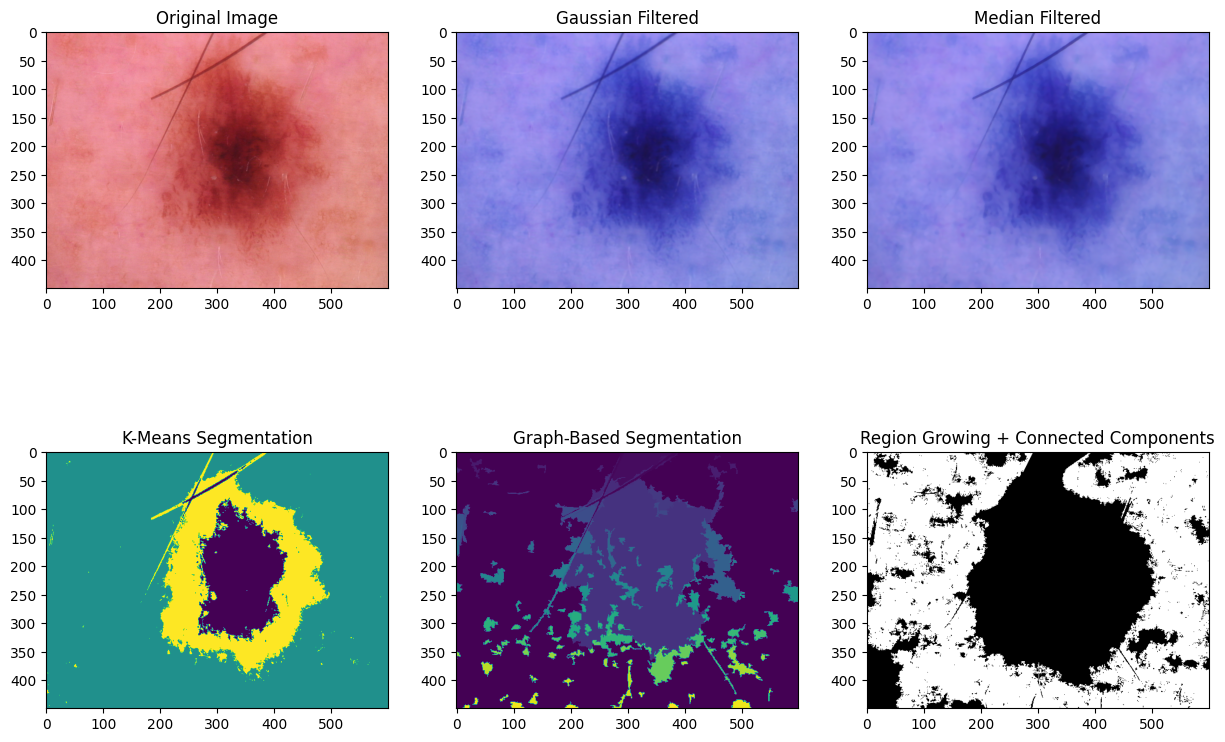

Segmentation Metrics: {'IoU': 0.025357670600090608, 'Dice': 0.0005043449965675235, 'Pixel Accuracy': 0.12525555555555556}


In [14]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original Image")
axes[0, 1].imshow(gaussian_filtered)
axes[0, 1].set_title("Gaussian Filtered")
axes[0, 2].imshow(median_filtered)
axes[0, 2].set_title("Median Filtered")
axes[1, 0].imshow(kmeans_result)
axes[1, 0].set_title("K-Means Segmentation")
axes[1, 1].imshow(graph_result)
axes[1, 1].set_title("Graph-Based Segmentation")
axes[1, 2].imshow(cleaned_mask, cmap='gray')
axes[1, 2].set_title("Region Growing + Connected Components")
plt.show()

print("Segmentation Metrics:", metrics)

K-Means Metrics: {'IoU': 0.8671281215677195, 'Dice': 0.0075254604436779575, 'Pixel Accuracy': 0.6627197265625}
Graph Segmentation Metrics: {'IoU': 0.7386810102554405, 'Dice': 0.007801097298931175, 'Pixel Accuracy': 0.67376708984375}
Region Growing Metrics: {'IoU': 0.5157997762623135, 'Dice': 0.007730598848482584, 'Pixel Accuracy': 0.672607421875}


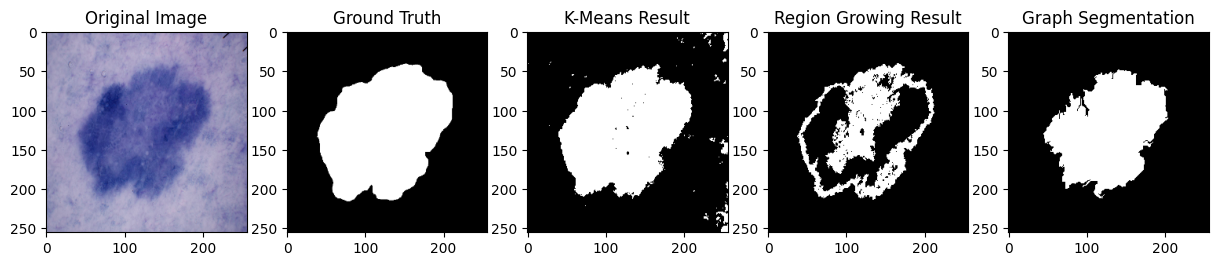

In [34]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.filters import threshold_otsu

# Load and preprocess data
IMG_SIZE = 256
IMAGE_DIR = "./images"
MASK_DIR = "./ground"
BATCH_SIZE = 200

# Get image-mask pairs
def load_data():
    image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])
    mask_files = sorted([f.replace('.jpg', '_segmentation.png') for f in image_files])
    images, masks = [], []
    
    idx = np.random.randint(len(image_files))  # Select one random image
    img_name, mask_name = image_files[idx], mask_files[idx]
    
    img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    
    mask = cv2.imread(os.path.join(MASK_DIR, mask_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = np.expand_dims(mask, axis=-1)
    
    return img, mask

# K-Means Segmentation
def kmeans_segmentation(image, k=2):
    reshaped = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reshaped)
    segmented = labels.reshape(image.shape[:2])
    return (segmented * 255).astype(np.uint8)

# Graph-Based Segmentation (Binary Mask Output)
def graph_segmentation(image, scale=100, min_size=500):
    segments = felzenszwalb(image, scale=scale, min_size=min_size)
    unique, counts = np.unique(segments, return_counts=True)
    
    sorted_counts = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)
    lesion_label = sorted_counts[1][0] if len(sorted_counts) > 1 else sorted_counts[0][0]
    
    binary_mask = segments == lesion_label
    return (binary_mask * 255).astype(np.uint8)

# Region Growing
def region_growing(image, seed_point, threshold=20):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray, dtype=np.uint8)
    
    h, w = gray.shape
    stack = [seed_point]
    
    while stack:
        x, y = stack.pop()
        if 0 <= x < w and 0 <= y < h and mask[y, x] == 0 and abs(int(gray[y, x]) - int(gray[seed_point[1], seed_point[0]])) < threshold:
            mask[y, x] = 255
            stack.extend([(x+1, y), (x-1, y), (x, y+1), (x, y-1)])
    
    return mask

# Post-processing
def remove_small_regions(mask, min_size=500):
    mask = remove_small_objects(mask.astype(bool), min_size=min_size)
    mask = remove_small_holes(mask, area_threshold=min_size)
    return (mask.astype(np.uint8) * 255)

# Compute Metrics
def compute_metrics(pred, true):
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    iou = intersection / (union + 1e-6)
    dice = (2. * intersection) / (pred.sum() + true.sum() + 1e-6)
    pixel_acc = (pred == true).mean()
    return {"IoU": iou, "Dice": dice, "Pixel Accuracy": pixel_acc}

# Process One Random Image
image, ground_truth = load_data()

kmeans_result = kmeans_segmentation(image)
graph_result = graph_segmentation(image)
region_grow_result = region_growing(image, (IMG_SIZE//2, IMG_SIZE//2))
cleaned_mask = remove_small_regions(region_grow_result)

# Compute metrics for all methods
metrics_kmeans = compute_metrics(kmeans_result, ground_truth.squeeze())
metrics_graph = compute_metrics(graph_result, ground_truth.squeeze())
metrics_region_growing = compute_metrics(cleaned_mask, ground_truth.squeeze())

print(f"K-Means Metrics: {metrics_kmeans}")
print(f"Graph Segmentation Metrics: {metrics_graph}")
print(f"Region Growing Metrics: {metrics_region_growing}")

plt.figure(figsize=(15, 4))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 5, 2)
plt.imshow(ground_truth.squeeze(), cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 5, 3)
plt.imshow(kmeans_result, cmap='gray')
plt.title("K-Means Result")

plt.subplot(1, 5, 4)
plt.imshow(region_grow_result, cmap='gray')
plt.title("Region Growing Result")

plt.subplot(1, 5, 5)
plt.imshow(graph_result, cmap='gray')
plt.title("Graph Segmentation")

plt.show()

SVM Segmentation Metrics: {'IoU': 0.7352941175580617, 'Dice': 0.003349305246582372, 'Pixel Accuracy': 0.965087890625}


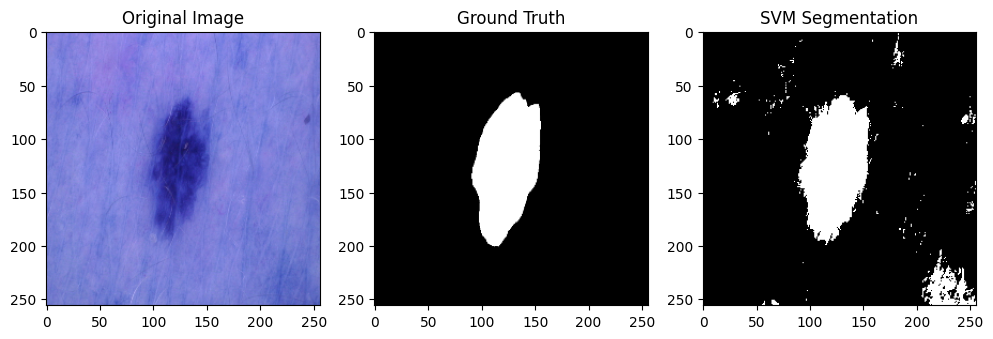

In [36]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import jaccard_score, accuracy_score

# Load and preprocess data
IMG_SIZE = 256
IMAGE_DIR = "./images"
MASK_DIR = "./ground"

def load_data():
    image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])
    mask_files = sorted([f.replace('.jpg', '_segmentation.png') for f in image_files])

    idx = np.random.randint(len(image_files))  # Select a random image
    img_name, mask_name = image_files[idx], mask_files[idx]

    img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    mask = cv2.imread(os.path.join(MASK_DIR, mask_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    return img, mask

# Train an SVM ensuring balanced sampling
def train_svm(image, mask, sample_size=500):
    # Reshape image to extract features (RGB channels)
    X = image.reshape(-1, 3)
    y = (mask.flatten() > 128).astype(int)  # Convert mask to binary (1 for lesion, 0 for background)

    # Ensure both classes are represented
    lesion_indices = np.where(y == 1)[0]  # Pixels belonging to lesion
    bg_indices = np.where(y == 0)[0]      # Pixels belonging to background

    # Sample from both classes
    num_lesion_samples = min(sample_size // 2, len(lesion_indices))
    num_bg_samples = min(sample_size // 2, len(bg_indices))

    if num_lesion_samples == 0 or num_bg_samples == 0:
        raise ValueError("Not enough diversity in the image to sample both classes.")

    sampled_lesion = np.random.choice(lesion_indices, num_lesion_samples, replace=False)
    sampled_bg = np.random.choice(bg_indices, num_bg_samples, replace=False)

    # Combine the selected samples
    sampled_indices = np.concatenate([sampled_lesion, sampled_bg])
    X_train, y_train = X[sampled_indices], y[sampled_indices]

    # Train SVM classifier
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)

    return svm

# Perform segmentation using trained SVM
def segment_with_svm(svm, image):
    X_test = image.reshape(-1, 3)  # Extract features
    y_pred = svm.predict(X_test)   # Predict labels
    segmented = y_pred.reshape(image.shape[:2])  # Reshape back to image dimensions
    return (segmented * 255).astype(np.uint8)  # Convert to binary mask

# Load image and ground truth
image, ground_truth = load_data()

# Train SVM on selected pixels
svm_model = train_svm(image, ground_truth)

# Perform segmentation
svm_result = segment_with_svm(svm_model, image)

# Compute Metrics
def compute_metrics(pred, true):
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    iou = intersection / (union + 1e-6)
    dice = (2. * intersection) / (pred.sum() + true.sum() + 1e-6)
    pixel_acc = (pred == true).mean()
    return {"IoU": iou, "Dice": dice, "Pixel Accuracy": pixel_acc}

metrics = compute_metrics(svm_result, ground_truth)
print(f"SVM Segmentation Metrics: {metrics}")

# Display Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(svm_result, cmap='gray')
plt.title("SVM Segmentation")

plt.show()


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from tqdm import tqdm  # Progress Bar

# Load and preprocess data
IMG_SIZE = 256
IMAGE_DIR = "./images"
MASK_DIR = "./ground"
NUM_SAMPLES = 500  # Use only 500 samples
BATCH_SIZE = 50  # Mini-batch size

# Get image-mask pairs
def load_data():
    image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])[:NUM_SAMPLES]
    mask_files = sorted([f.replace('.jpg', '_segmentation.png') for f in image_files])

    images, masks = [], []
    
    for img_name, mask_name in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Loading Data"):
        img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalize

        mask = cv2.imread(os.path.join(MASK_DIR, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalize
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load data
images, masks = load_data()
print(f"Loaded {len(images)} images.")

# Prepare training data (Flatten pixels for SVM)
X_train = images.reshape(len(images), -1)  # Convert images to feature vectors
y_train = masks.reshape(len(masks), -1)  # Convert masks to label vectors

# Train SVM in batches
svm_model = SVC(kernel='linear', probability=True, random_state=42)

for i in tqdm(range(0, len(X_train), BATCH_SIZE), desc="Training SVM"):
    X_batch = X_train[i : i + BATCH_SIZE]
    y_batch = y_train[i : i + BATCH_SIZE].reshape(len(X_batch), -1)  # Keep batch size consistent

    if len(np.unique(y_batch)) > 1:  # Ensure multiple classes exist
        svm_model.fit(X_batch, y_batch.ravel())  # Flatten only inside fit()

print("✅ SVM Training Completed!")

# Perform segmentation
def segment_with_svm(model, image):
    img_vector = image.reshape(1, -1)  # Flatten image
    prediction = model.predict(img_vector)
    return prediction.reshape(IMG_SIZE, IMG_SIZE)  # Reshape back to original image size

# Test SVM on one image
test_image = images[0]
svm_result = segment_with_svm(svm_model, test_image)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(masks[0], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(svm_result, cmap='gray')
plt.title("SVM Segmentation Result")

plt.show()


Loading Data: 100%|██████████| 500/500 [00:03<00:00, 142.24it/s]


Loaded 500 images.


Training SVM:   0%|          | 0/10 [00:00<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [50, 3276800]